# Welcome to the QICK lab day 2 at the 2024 QIS Summer School!

### Day 1 agenda:
* Introducing our teaching team and welcoming you to the labs (~30 minutes)
* QubitControl notebook ("Show and Tell" style) (~45 min)
* Resonator notebook (More hands on work for you) (~45 min)

### Day 2 agenda:
* Discussion of superconducting qubit control pulse sequences (especially how to measure qubit T1) (~30 minutes)
* QubitReadout notebook (More hands on work for you) (~90 min)

```diff
+ Throughout both lab days, we will be asking you questions in green font! Please answer them in a new cell below the question.
```

# RF superconducting qubit readout 101

This example shows a basic demonstration of reading out an emulated qubit, including measurements of single shot readout fidelity, T1, and Rabi oscillation.

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from scipy.optimize import curve_fit

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D


from hist_analysis import hist_process

from qick.asm_v2 import QickParam
from scipy.stats import expon

In [2]:
from qick_training import *

# soc = QickTrainingSoc(bitfile="../fw/2024-07-19_4x2_tprocv2r20_kidsim/qick_4x2.bit")
soc = QickTrainingSoc(bitfile="../fw/2024-07-19_216_tprocv2r20_kidsim/qick_216.bit", force_init_clks=True)

soccfg = soc
print(soccfg)

resetting clocks: 245.76 491.52
QICK running on ZCU216, software version 0.2.282

Firmware configuration (built Fri Jul 19 13:04:20 2024):

	Global clocks (MHz): tProcessor 614.400, RF reference 245.760

	1 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3

	2 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 1
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 65536 decimated (213.333 us)
		triggered by tport 0, pin 0, feedback to tProc input 0
		ADC tile 2, blk 0 is 0_226, on JHC7
	1:	axis_readout_v2 - configured by PYNQ
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 65536 decimated (213.333 us)
		triggered by tport 1, pin 0, feedback to tProc input 1
		ADC tile 2, blk 1 is 1_226, on JHC8

	16 digital output pins

In [3]:
GEN_CH = 0
RO_CH = 0

# RF superconducting qubit readout 101

# We read a superconducting qubit out using the readout resonator that it is coupled to.

In these labs we will be studying qubit readout with both resonators we looked at and fit today.

The qubit being in a certain state (e.g. the ground state versus the excited state) causes a shift in the frequency of the qubit's readout resonator. This change of frequency causes a change in the complex S_21 of a readout tone transmitted through the fridge. 

# Refs for how to use a resonator to read out a qubit (recap from yesterday)

* 1. We use resonators to read out superconducting qubits in a way that does not destroy the quantum state of the qubit (quantum nondemolition readout), like we talked about in Monday's lecture. 
    * Our reference from lecture: https://arxiv.org/abs/2106.06173 
    
* 2. You can also do things the other way around, and use a superconducting qubit to read out the resonator, and store the quantum information in the resonator instead. 
    * This is used to search for axion dark matter, which is a useful practical application of today's noisy superconducting qubits: https://arxiv.org/abs/2008.12231

```diff
+ Q: Take a few minutes to review the concept of dispersive readout with your group/TA.
```
See Figure 3 of https://arxiv.org/pdf/2106.06173 which we talked about in the morning's lecture.

# Like yesterday, we will be using the QICK resonator emulator

```
Help on method config_resonator in module qick_training:

config_resonator(simu_ch=0, q_adc=6, q_dac=0, f=500.0, df=2.0, dt=10.0, c0=0.99, c1=0.8, verbose=False) method of qick_training.QickTrainingSoc instance
    Configure the resonator simulator.
    
    The two qout values truncate the data at different points in the simulator.
    They affect both the simulator gain and its dynamic range.
    Smaller values mean more gain, but you might saturate something and your decimated traces will look like garbage.
    The default values were chosen to avoid saturation at max pulse power (i.e. a gain-1 const pulse).
    
    Parameters
    ----------
    simu_ch : int
        index of the simulator you want to configure
    q_adc : int
        number of bits to truncate at simulator input
        this basically sets the input's dynamic range
    q_dac : int
        number of bits to truncate at simulator output
        this basically sets the output power
    f : float
        resting frequency of the resonator, in MHz
    df : float
        size of the frequency jump, in MHz
        after the jump, the resonator freq will be f-df
    dt : float
        jump duration, in us
        the resonator will jump back to its rest state after this time
    c0 : float
        resonator parameter, in the range 0.0 - 1.0
        roughly speaking, this sets the width scale of the resonator
    c1 : float
        resonator parameter, in the range 0.0 - c0
        roughly speaking, this sets the depth of the resonator minimum
```

```diff
+ Q: Take a few minutes to review the above parameters of your resonator that you can configure.
```

# T1 decay 
When a qubit decays from its excited state to its ground state, its readout resonator jumps back from “e”to “g” instantaneously at random times given by a Poisson distribution with a time scale set by the qubit’s T1 time. In this lab, we will emulate T1 decay.

## Set up some utility code

In [4]:
def prepare_program(soc, soccfg, config, reps, loops=1):
    # we put the resonator in excited state before start of RO, and make sure its max lifetime extends past the end of RO
    # the resonator simulator can't actually decay randomly - it always decays after a fixed time
    # so we set the resonator to decay after DECAY_DELAY, and put it in excited state at lifetime-DECAY_DELAY
    # need to make sure your readout doesn't go past MAX_LIFETIME
    
    # let's say the pulse starts at t in [0, tmax_pulse] and the pulse length is pulse_len
    # the readout starts at t in [t_ro, t_ro+tmax_pulse] and the readout window is ro_len
    # the resonator decays at t in [-res_pad, t_ro+tmax_pulse+ro_len+res_pad]
    # so we'll set DECAY_DELAY = t_ro + tmax_pulse + ro_len + 2*res_pad
    # and start the jumps at -res_pad-DECAY_DELAY, with a range of DECAY_DELAY
    # the readout and resonator trigger have time offsets
    TOFF_RO = 3.5
    TOFF_RES = 0.8
    RES_PAD = 0.2

    if reps+1 > soccfg['tprocs'][0]['dmem_size']:
        raise RuntimeError("reps=%d exceeds maximum of %d-1"%(reps, soccfg['tprocs'][0]['dmem_size']))
    
    class T1Program(AveragerProgramV2):
        def _initialize(self, cfg):
            ro_ch = cfg['ro_ch']
            gen_ch = cfg['gen_ch']
            f_ro = cfg['f_res']+cfg['df_ro']
            
            self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
            self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
            self.add_readoutconfig(ch=ro_ch, name="myro", freq=f_ro, gen_ch=gen_ch)
    
            self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                           style="const", 
                           freq=f_ro, 
                           length=cfg['pulse_len'],
                           phase=cfg['phase'],
                           gain=cfg['pulse_gain'], 
                          )

            for i in range(loops):
                self.add_loop("myloop%d"%(i+1), self.cfg["steps"])
            
        def _body(self, cfg):
            # configure the readout
            self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
            
            # read a value from the data memory into the time register (s14)
#             self.add_macro(DerefDmem(reg="s14", idx='reps'))
            self.read_dmem(dst='s_out_time', addr='reps')
            if cfg['do_jump']:
                self.trigger(pins=list(range(8,16)), t=None)
                
            self.delay(RES_PAD+cfg['decay_delay']-TOFF_RES)
            self.pulse(ch=cfg['gen_ch'], name="mypulse", t=cfg['t_pulse'])
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['t_pulse']+cfg['t_ro']+TOFF_RO)
            self.delay(cfg['decay_delay']+TOFF_RO)
            
        def compile_datamem(self):
            t1 = self.cfg['t1']
            # would like to use us2cycles, but that only takes scalars
            if t1==0:  delays = 0
            elif t1<0: delays = self.cfg['decay_delay']
            else:      delays = np.minimum(t1*expon.rvs(size=self.reps), self.cfg['decay_delay'])
    
            # the jump time for rep i will be dmem[reps - i]        
            dmem = np.zeros(self.reps+1, dtype=np.int32)
            dmem[1:] = np.round(delays*soccfg['tprocs'][0]['f_time'])
            return dmem
    
    cfg = config.copy()
    cfg['gen_ch'] = GEN_CH
    cfg['ro_ch'] = RO_CH
    cfg['nqz'] = 1
    cfg['phase'] = 0
    cfg['decay_delay'] = cfg['t_ro'] + cfg['t_pulse'] + cfg['ro_len'] + 2*RES_PAD
    if isinstance(cfg['decay_delay'], QickParam):
        cfg['decay_delay'] = cfg['decay_delay'].maxval()
    q_dac = min(cfg['truncate'], 11)
    q_adc = 6 + cfg['truncate']-q_dac
    
    soc.config_resonator(dt=cfg['decay_delay'], f=cfg['f_res'], df=-cfg['df_res'], c0=cfg['c0'], c1=cfg['c1'], q_dac=q_dac, q_adc=q_adc)
    cfg['do_jump'] = False
    progG = T1Program(soccfg, reps=reps, final_delay=1.0, cfg=cfg)
    cfg['do_jump'] = True
    progE = T1Program(soccfg, reps=reps, final_delay=1.0, cfg=cfg)
    return progG, progE

def make_sweep_axis(cfg, parname):
    """takes a config dict, makes a 1-D array usable as a plot axis
    """
    param = cfg[parname]
    return np.linspace(param.minval(), param.maxval(), cfg['steps'])

## Set fixed parameters: resonator properties, qubit coupling, and the maximum power for a good dispersive readout.

T1 is also really a fixed parameter, but we'll be changing it a lot.

In [5]:
### Resonator properties
cfg_res = {'f_res': 500.0, # resonator's ground state frequency
          'c0': 0.99, # resonator strength
          'c1': 0.8, # resonator bandwidth
          'df_res': -1.0, # resonator jump size
          'truncate': 12, # simulator output power (0 for max SNR, larger integers for more realism)
          'pulse_gain': 0.7, # readout power
          }

## Set readout parameters
These may not be optimal; you can come back here to change them.

In [6]:
cfg_ro = {'df_ro': -0.5, # offset of RO freq relative to f_res; set to df_res/2 to read at midpoint
          't_pulse': 0,
          't_ro': 0, # RO delay
          'pulse_len': 3,
          'ro_len': 3,
           }

## First, lets start with no T1 decay and look at the two states when reading at the midpoint between the resonator "g" frequency and resonator "e" frequency.

```diff
+ Q. Check what df_ro and df_res are. Are we currently configured to read out at the midpoint?
```

In [7]:
## Solution: Yes.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

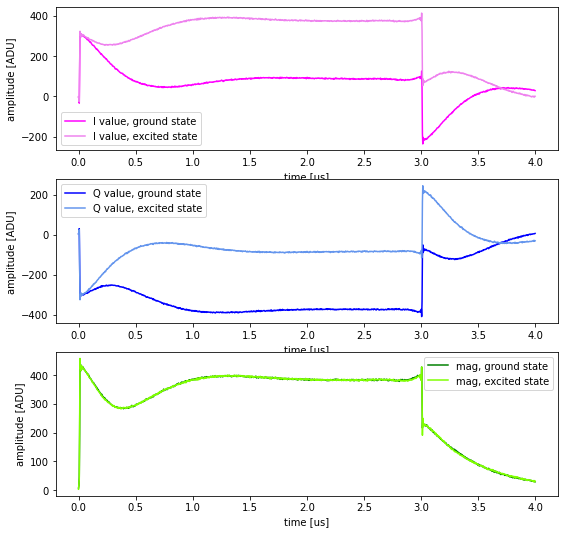

In [8]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['truncate'] = 0
config['pulse_gain'] = 1.0
config['ro_len'] += 1.0

progG, progE = prepare_program(soc, soccfg, config, reps=1)

iq_list = [x.acquire_decimated(soc, soft_avgs=1)[0] for x in [progG, progE]]
t = progE.get_time_axis(ro_index=0)
labels = ['ground state', 'excited state']

fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list):
    if labels[ii] == "ground state":
        axes[0].plot(t, iq[:,0], label="I value, %s"%(labels[ii]), color="magenta")
        axes[1].plot(t, iq[:,1], label="Q value, %s"%(labels[ii]), color="blue")
        axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, %s"%(labels[ii]), color="green")
    else:
        axes[0].plot(t, iq[:,0], label="I value, %s"%(labels[ii]), color="violet")
        axes[1].plot(t, iq[:,1], label="Q value, %s"%(labels[ii]), color="cornflowerblue")
        axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, %s"%(labels[ii]), color="chartreuse")
for plot in axes:
    plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

```diff
+ Q. Do the signals have the same magnitude? Do the signals have the same phase?
```

In [9]:
### Solution: Yes, No.

```diff
+ Q. Explain what is happening >3 us.
```

In [10]:
### Solution: The resonator is ringing down, no longer being driven.

```diff
+ Q. Change df_ro so that you are reading at the qubit ground state frequency.
```

In [11]:
### Solution: 
cfg_ro = {'df_ro': 0, # offset of RO freq relative to f_res; set to df_res/2 to read at midpoint
          't_pulse': 0,
          't_ro': 0, # RO delay
          'pulse_len': 3,
          'ro_len': 3,
           }

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

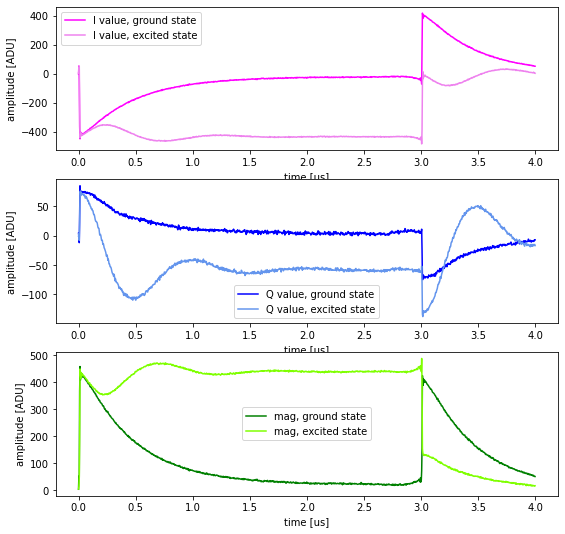

In [12]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['truncate'] = 0
config['pulse_gain'] = 1.0
config['ro_len'] += 1.0

progG, progE = prepare_program(soc, soccfg, config, reps=1)

iq_list = [x.acquire_decimated(soc, soft_avgs=1)[0] for x in [progG, progE]]
t = progE.get_time_axis(ro_index=0)
labels = ['ground state', 'excited state']

fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list):
    if labels[ii] == "ground state":
        axes[0].plot(t, iq[:,0], label="I value, %s"%(labels[ii]), color="magenta")
        axes[1].plot(t, iq[:,1], label="Q value, %s"%(labels[ii]), color="blue")
        axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, %s"%(labels[ii]), color="green")
    else:
        axes[0].plot(t, iq[:,0], label="I value, %s"%(labels[ii]), color="violet")
        axes[1].plot(t, iq[:,1], label="Q value, %s"%(labels[ii]), color="cornflowerblue")
        axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, %s"%(labels[ii]), color="chartreuse")
for plot in axes:
    plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

```diff
+ Q. Explain why the signal has a small magnitude when measuring the ground state but a large magnitude when measuring the excited state. Draw a picture to explain to your TA.
```

In [13]:
# Because you're measuring relative to the ground state.

```diff
+ Q. Change df_ro so that you are reading at the resonators "e" frequency.
```

In [14]:
### Solution: 
cfg_ro = {'df_ro': -1, # offset of RO freq relative to f_res; set to df_res/2 to read at midpoint
          't_pulse': 0,
          't_ro': 0, # RO delay
          'pulse_len': 3,
          'ro_len': 3,
           }

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

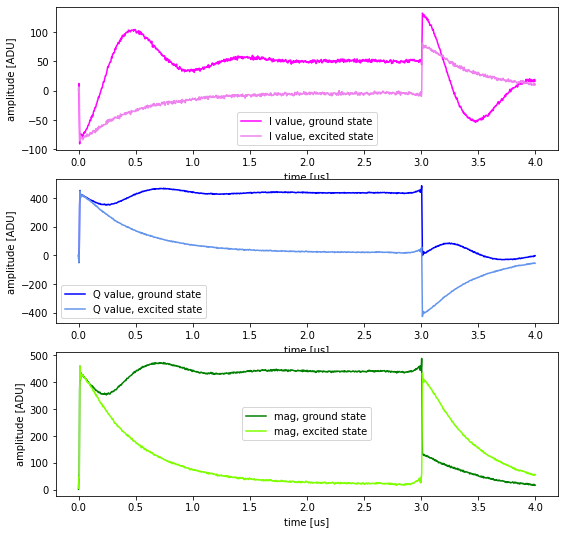

In [15]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['truncate'] = 0
config['pulse_gain'] = 1.0
config['ro_len'] += 1.0

progG, progE = prepare_program(soc, soccfg, config, reps=1)

iq_list = [x.acquire_decimated(soc, soft_avgs=1)[0] for x in [progG, progE]]
t = progE.get_time_axis(ro_index=0)
labels = ['ground state', 'excited state']

fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list):
    if labels[ii] == "ground state":
        axes[0].plot(t, iq[:,0], label="I value, %s"%(labels[ii]), color="magenta")
        axes[1].plot(t, iq[:,1], label="Q value, %s"%(labels[ii]), color="blue")
        axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, %s"%(labels[ii]), color="green")
    else:
        axes[0].plot(t, iq[:,0], label="I value, %s"%(labels[ii]), color="violet")
        axes[1].plot(t, iq[:,1], label="Q value, %s"%(labels[ii]), color="cornflowerblue")
        axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, %s"%(labels[ii]), color="chartreuse")
for plot in axes:
    plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

```diff
+ Q. Explain why the signal has a large magnitude when measuring the ground state but a small magnitude when measuring the excited state. Draw a picture to explain this to your TA.
```

In [16]:
# Because you're measuring relative to the excited state.

# Single shot readout, no T1 decay


The qubit being in a certain state (e.g. the ground state versus the excited state) causes a shift in the frequency of the qubit's readout resonator. This change of frequency causes a change in the complex S_21 of a readout tone transmitted through the fridge. 

When you take a single shot of measurement, by measuring the resonator frequency you can find out the state of the qubit without destroying that state. In general you are discriminating between two blobs, or two trajectories, in IQ space, since you will read out the resonator at two locations (qubit in ground state, vs. qubit in excited state). 

In a real experiment, you might read out at the ground or excited state frequency and look at the transmission amplitude, or read out at the midpoint and look at the phase.

We measure the "readout fidelity" of our qubit system by preparing the qubit in the excited state and in the ground state and looking at the IQ distribution of the readout signal in both cases:

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Threshold=  -156.45994816833638


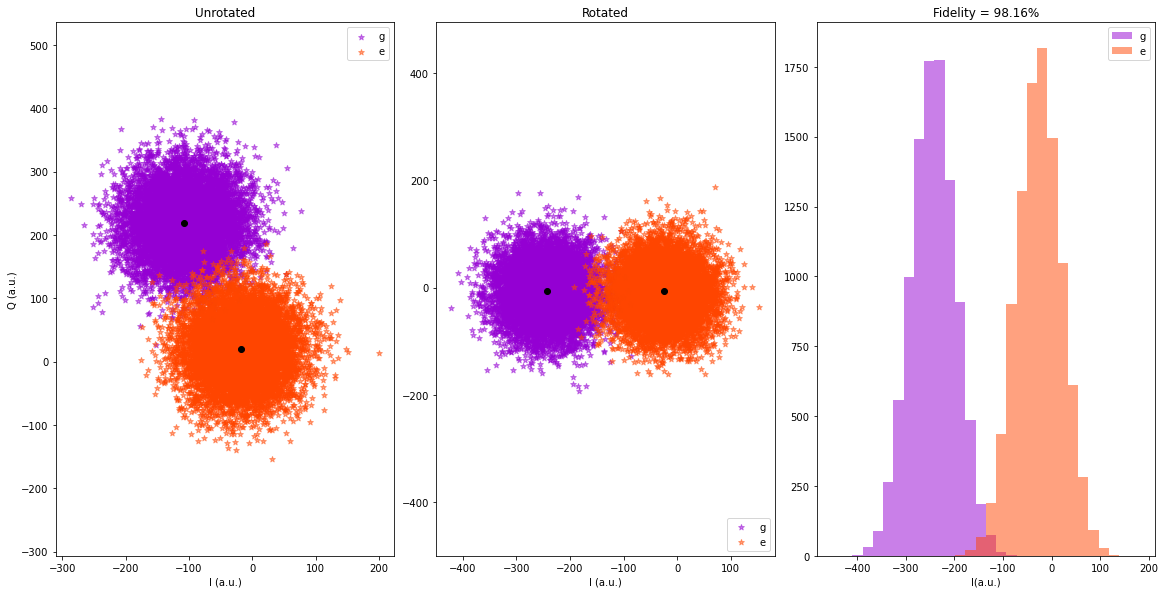

In [17]:
cfg_expt = {'steps' : 10, # number of sweep steps, increase it to get more shots without increasing reps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0].reshape([-1,2]) for x in [progG, progE]]

data = [iq_raw[0][:,0], iq_raw[0][:,1], iq_raw[1][:,0], iq_raw[1][:,1]]
fid, threshold, theta, xlims = hist_process(data)
print("Threshold= ", threshold)

threshold /= progE.get_time_axis(ro_index=0, length_only=True)
#  We save the thresholds we got from the no-decay measurement. 
# Note that we need to normalize the threshold to the readout window length.

```diff
+ Q. Why do you think you see a histogram with some width instead of a straight line that divides the g and e. If you look at two blobs, why do you think you see blobs and not just 2 dots? 
```

In [18]:
### Solution:
# You have noise. Noise in the DAC and the ADC, 
# in the real system youll have noise from different sources including amplifiers etc.
# You also have photons worth of quantum limited noise.

```diff
+ Q. What would it look like if readout fidelity was 0%? 100%?
```

In [19]:
### Solution:
# 0% blobs totally on top of each other, 100% blobs totally separate.

```diff
+ Q. Change T1 to 0. What do you expect to see?
```

In [20]:
### Solution:
# All population from the excited blob in the ground blob.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Threshold=  -216.72351438846889


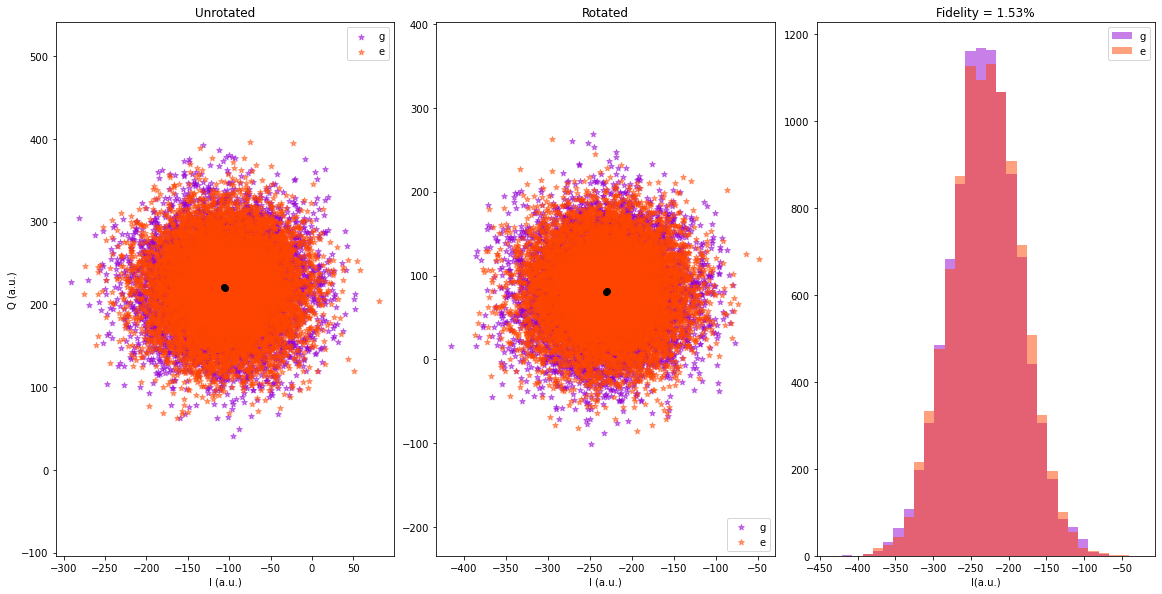

In [21]:
cfg_expt = {'steps' : 10, # number of sweep steps, increase it to get more shots without increasing reps
          't1': 0, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0].reshape([-1,2]) for x in [progG, progE]]

data = [iq_raw[0][:,0], iq_raw[0][:,1], iq_raw[1][:,0], iq_raw[1][:,1]]
fid, threshold, theta, xlims = hist_process(data)
print("Threshold= ", threshold)

threshold /= progE.get_time_axis(ro_index=0, length_only=True)
#  We save the thresholds we got from the no-decay measurement. 
# Note that we need to normalize the threshold to the readout window length.

```diff
+ Q. Change T1 to 1 us. What do you expect to see?
```

In [22]:
### Solution:
# Most population in the excited blob has moved to the ground blob, lowering the readout fidelity.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Threshold=  -219.94962605166808


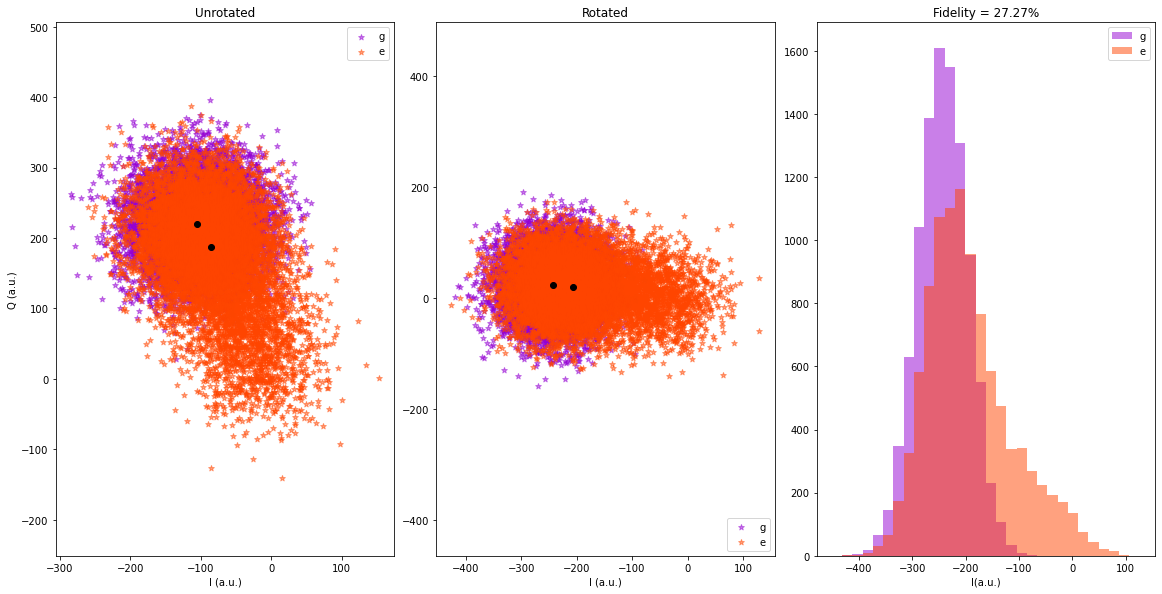

In [23]:
cfg_expt = {'steps' : 10, # number of sweep steps, increase it to get more shots without increasing reps
          't1': 1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0].reshape([-1,2]) for x in [progG, progE]]

data = [iq_raw[0][:,0], iq_raw[0][:,1], iq_raw[1][:,0], iq_raw[1][:,1]]
fid, threshold, theta, xlims = hist_process(data)
print("Threshold= ", threshold)

threshold /= progE.get_time_axis(ro_index=0, length_only=True)

#  We save the thresholds we got from the no-decay measurement. 
# Note that we need to normalize the threshold to the readout window length.

In [24]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': 1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['truncate'] = 0
config['pulse_gain'] = 1.0
print(config)

progE = prepare_program(soc, soccfg, config, reps=50)[1]

iq_list = progE.acquire_decimated(soc, soft_avgs=1)[0]
t = progE.get_time_axis(ro_index=0)

{'f_res': 500.0, 'c0': 0.99, 'c1': 0.8, 'df_res': -1.0, 'truncate': 0, 'pulse_gain': 1.0, 'df_ro': -1, 't_pulse': 0, 't_ro': 0, 'pulse_len': 3, 'ro_len': 3, 'steps': 1, 't1': 1}


  0%|          | 0/1 [00:00<?, ?it/s]

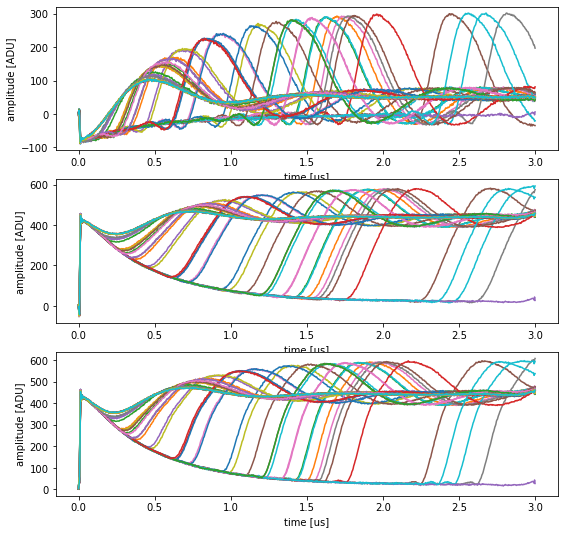

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list):
    axes[0].plot(t, iq[:,0], label="I value, step %d"%(ii))
    axes[1].plot(t, iq[:,1], label="Q value, step %d"%(ii))
    axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
for plot in axes:
#     plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

```diff
+ Q. What, physics-wise, are the different traces here?
+ Q: When did each of these traces decay? Compare to the relevant trace you saw when reading out at the excited state frequency?
```

In [26]:
### Solution:
# Each trace is a different "shot" of measurement happening given that the qubit's T1 time is 1 us.

```diff
+ Q. Run the above cells with no T1 decay, immediate T1 decay, and a finite T1 decay. Explain why the signal in each case makes sense. Try when reading at the ground vs. excited state frequency, do you see what you expect to see?
```

# T1 measurement

You've already computed the readout fidelity given an amount of T1 decay to obtain `threshold`, `theta` values. Next, choose the `T1` time of your emulated qubit. Then you will be ready to emulate the T1 decay curve.

### First, find the single-shot readout threshold for your updated (realistic) T1 time.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Threshold=  -168.99137909046294


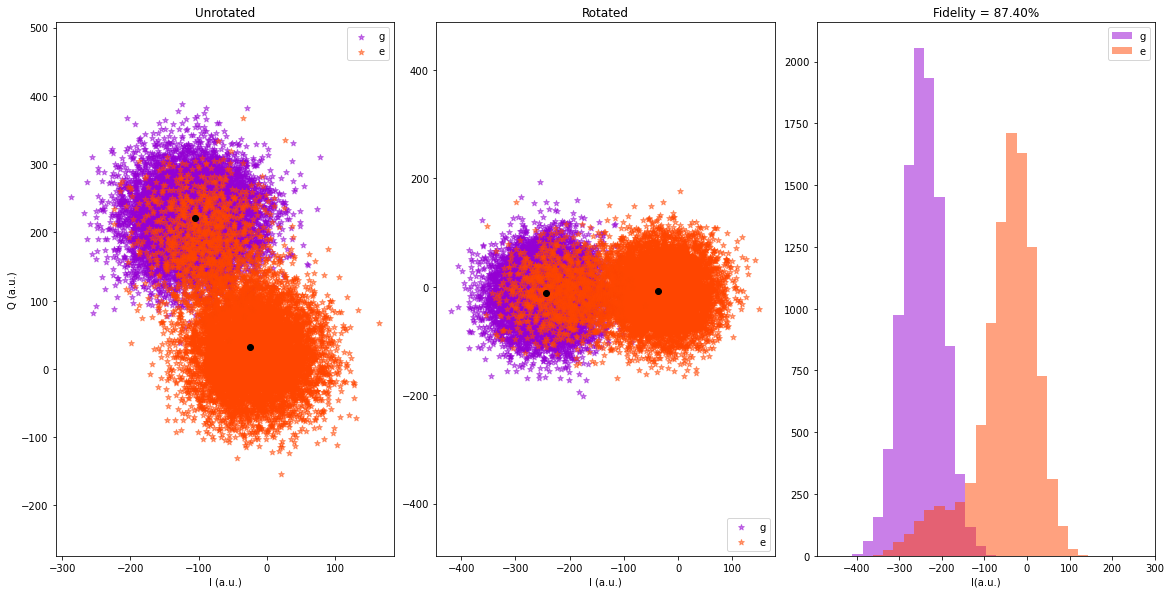

In [27]:
cfg_expt = {'steps' : 10, # number of sweep steps, increase it to get more shots without increasing reps
          't1': 15, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0].reshape([-1,2]) for x in [progG, progE]]

data = [iq_raw[0][:,0], iq_raw[0][:,1], iq_raw[1][:,0], iq_raw[1][:,1]]
fid, threshold, theta, xlims = hist_process(data)
print("Threshold= ", threshold)

threshold /= progE.get_time_axis(ro_index=0, length_only=True)

#  We save the thresholds we got from the no-decay measurement. 
# Note that we need to normalize the threshold to the readout window length.

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

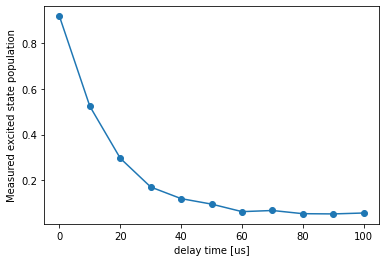

In [28]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': 15, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['t_pulse'] = QickSweep1D("myloop1", 0, 100)
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]

t = make_sweep_axis(config, 't_pulse')


plt.plot(t, iq_list[1][0,:,0], marker='o')

plt.ylabel("Measured excited state population")
plt.xlabel("delay time [us]");

```diff
+ Q. Fit the data of this curve to an exponential decay using the `curve_fit` function. Overlay the fit to the data. What is the T1 of this decay curve according to your fit? What is the error on your fitted T1? 
```

In [29]:
# fit model, accounting for infidelity
def t1_model(t, p0, t1, fid_g):
    p = p0*np.exp(-t/t1)
    return p*fid_g + (1-p)*(1-fid_g)

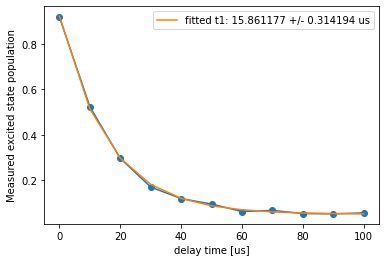

In [30]:
## Solution:

guess = [1.0, 10, 0]
popt, pcov = curve_fit(t1_model, t, [iq_list[1][0,i,0] for i in range(cfg_expt['steps'])], p0 = guess)

plt.plot(t, iq_list[1][0,:,0], marker='o')

plt.ylabel("Measured excited state population")
plt.xlabel("delay time [us]");
plt.plot(t, t1_model(t, *popt), label='fitted t1: %f +/- %f us'%(popt[1], np.sqrt(pcov[1][1])))
plt.legend()


# So... our qubit-resonator system is imperfect and gives us readout infidelity. We have a 15 us T1. How can we optimize readout fidelity given our system?

# Optimize your readout fidelity: vary readout frequency

  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

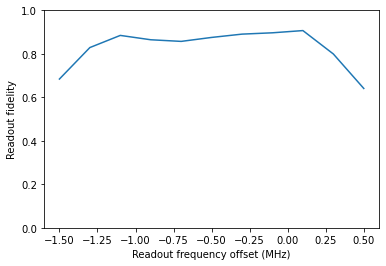

In [31]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': 15, #15, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['df_ro'] = QickSweep1D("myloop1", 0.5, -1.5) # offset of RO freq relative to f_res; set to df_res/2 to read at midpoint
progG, progE = prepare_program(soc, soccfg, config, reps=10000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

df = progE.get_pulse_param("mypulse","freq", as_array=True)-config['f_res']

fid = []
for i,_ in enumerate(df):
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(df, fid)
plt.ylabel("Readout fidelity")
plt.ylim(0,1)
plt.xlabel("Readout frequency offset (MHz)");

```diff
+ Q. What is our optimal readout frequency for this qubit-resonator setup? Would we be more successful doing amplitude or phase readout? Try with T1 decay, does anything change?
```

In [32]:
## Solution:
# optimal readout is at either end of the frequency range ("amplitude readout" as opposed to "phase readout")

# Optimize your readout fidelity: vary readout pulse amplitude

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

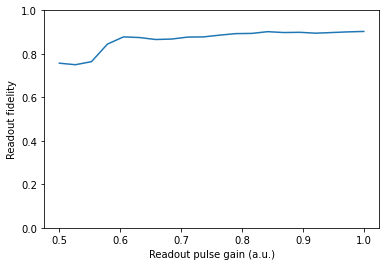

In [33]:
cfg_expt = {'steps' : 20, # number of sweep steps
          't1': 15, #15, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['pulse_gain'] = QickSweep1D("myloop1", 0.5, 1.0)
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

gains = progE.get_pulse_param("mypulse","gain", as_array=True)

fid = []
for i in range(cfg_expt['steps']):
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(gains, fid)
plt.ylabel("Readout fidelity")
plt.ylim(0,1)
plt.xlabel("Readout pulse gain (a.u.)");

```diff
+ Q. What is our optimal readout pulse gain for this qubit-resonator setup? Why does this make sense? Does this make sense for a real life qubit-resonator system? Try with T1 decay, does anything change?
```

In [34]:
### Pulse amplitude
# more readout power is good, better SNR higher signal. In real life putting too many photons into the resonator
# disturbs QND-ness and eventually disturbs the ability to be able to see the qubit at all.

# Optimize your readout fidelity: vary readout pulse length

{'f_res': 500.0, 'c0': 0.99, 'c1': 0.8, 'df_res': -1.0, 'truncate': 12, 'pulse_gain': 0.7, 'df_ro': -1, 't_pulse': 0, 't_ro': 0, 'pulse_len': 3, 'ro_len': 3, 'steps': 11, 't1': 15}


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

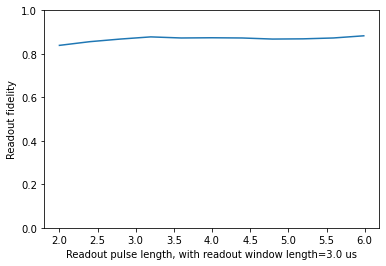

In [35]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': 15, #15, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
print(config)
config['pulse_len'] = QickSweep1D("myloop1", 2, 6)
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

pulse_len = progE.get_pulse_param("mypulse","length", as_array=True)

fid = []
for i in range(cfg_expt['steps']):
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(pulse_len, fid)
plt.ylabel("Readout fidelity")
plt.ylim(0,1)
plt.xlabel("Readout pulse length, with readout window length=%.1f us"%(config['ro_len']));

```diff
+ Q. Do you want your readout pulse length to be shorter than your readout window? Why or why not? Try with T1 decay, does anything change?
```

In [36]:
### Solution:
#  You want the readout pulse to be at least as long as the readout window.

# Optimize your readout fidelity: vary readout pulse time offset

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

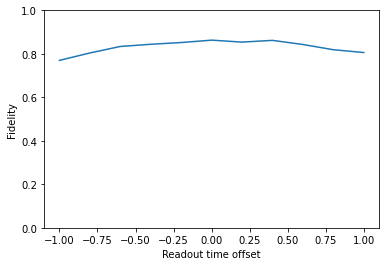

In [37]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': 15, #15, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['t_ro'] = QickSweep1D("myloop1", -1.0, 1.0)
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

t_ro = make_sweep_axis(config, 't_ro')

fid = []
for i in range(cfg_expt['steps']):
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(t_ro, fid)
plt.ylabel("Fidelity")
plt.ylim(0,1)
plt.xlabel("Readout time offset");

```diff
+ Q. Do you want to start reading out at the very moment the readout pulse enters the ADC, before, or after? Try with T1 decay, does anything change?
```

In [38]:
### Solution:
#  For this resonator, it seems optimal to start integrating at the start of the readout pulse, or slightly after.

# So, we should change the pulse and readout lengths together.

  0%|          | 0/11 [00:00<?, ?it/s]

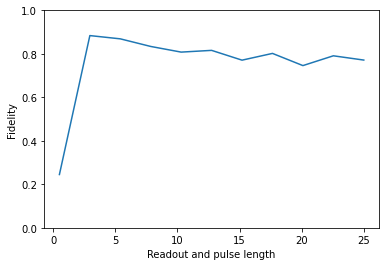

In [39]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': 15, #15, # negative for no decay, 0 to immediately decay
         }

config = {**cfg_res, **cfg_ro, **cfg_expt}
ro_lens = np.linspace(0.5, 25, 11)

fid = []
for i, ro_len in enumerate(tqdm(ro_lens)):
    config['ro_len'] = ro_len
    config['pulse_len'] = ro_len
    progG, progE = prepare_program(soc, soccfg, config, reps=1000)
    
    iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1, progress=False)[0] for x in [progG, progE]]
    iq_raw = [x.get_raw()[0] for x in [progG, progE]]
    i=0
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(ro_lens, fid)
plt.ylabel("Fidelity")
plt.ylim(0,1)
plt.xlabel("Readout and pulse length");

```diff
+ Q. Why does readout fidelity get worse as readout and pulse length get longer? Try with T1 decay, does anything change?
```

In [40]:
### Solution:
#  T1 decay happens during the readout.

```diff
+ Q. If your qubit T1 time is 1 us, how long should you read out for?
```

In [41]:
### Solution:
#  ~1 us... you need to integrate for a while to get SNR but T1 happens...

# In practice, we do 2D readout optimization sweeps, this saves time!

  0%|          | 0/121000 [00:00<?, ?it/s]

  0%|          | 0/121000 [00:00<?, ?it/s]

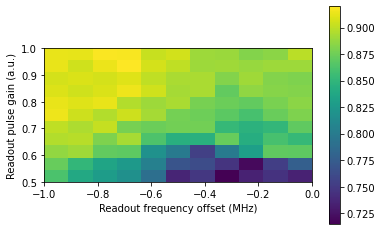

In [42]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': 15, #15, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['pulse_gain'] = QickSweep1D("myloop1", 0.5, 1.0)
config['df_ro'] = QickSweep1D("myloop2", 0, -1.0) 

progG, progE = prepare_program(soc, soccfg, config, reps=1000, loops=2)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

pulse_len = make_sweep_axis(config, 'df_ro')
t_ro = make_sweep_axis(config, 'pulse_gain')

fid = np.zeros([config['steps']]*2)
for i in range(cfg_expt['steps']):
    for j in range(cfg_expt['steps']):
        data = [iq_raw[0][:,i,j,0,0], iq_raw[0][:,i,j,0,1], iq_raw[1][:,i,j,0,0], iq_raw[1][:,i,j,0,1]]
        fid[i][j] = hist_process(data, plot=False)[0]

extent = [config['df_ro'].minval(), config['df_ro'].maxval(), config['pulse_gain'].minval(), config['pulse_gain'].maxval()]

plt.imshow(fid, extent=extent, aspect=1, origin="lower");
plt.ylabel("Readout pulse gain (a.u.)");
plt.xlabel("Readout frequency offset (MHz)");
plt.colorbar()

```diff
+ Q. Try with T1 decay, does anything change?
```